###  k-prediction 

Here are some codes for testing the hydrogeological parameters 
computing for permeaibility coefficient k prediction 

In [27]:
#Import necessaries modules 
import os 
import pandas as pd 
import numpy as np
from watex.datasets import load_hlogs 
from watex.utils import read_data 
from watex.utils.funcutils import sanitize_frame_cols 
%matplotlib inline 

In [28]:
# read  the main data from "hf_file" 
data = read_data ('data/boreholes/hf.csv') 
# load_hlogs to get the features names and target names 
box = load_hlogs () 
X0, y0 = data [box.feature_names] , data [box.target_names ] 
# make a copies for safety 
X, y = X0.copy() , y0.copy() 
# let visualize the features names and target names 
print("feature_names:\n" , box.feature_names ) 
print("traget names:\n", box.target_names ) 

feature_names:
 ['hole_id', 'depth_top', 'depth_bottom', 'strata_name', 'rock_name', 'layer_thickness', 'resistivity', 'gamma_gamma', 'natural_gamma', 'sp', 'short_distance_gamma', 'well_diameter']
traget names:
 ['aquifer_group', 'pumping_level', 'aquifer_thickness', 'hole_depth_before_pumping', 'hole_depth_after_pumping', 'hole_depth_loss', 'depth_starting_pumping', 'pumping_depth_at_the_end', 'pumping_depth', 'section_aperture', 'k', 'kp', 'r', 'rp', 'remark']


In [29]:
# data contain some categorical values, we will drop the rockname , the hole_id and well diameter which are subjective data and not usefull for prediction 
#puposes and impute  the remain data using bi-impute strategy 
#-------------------------------------------------
from watex.utils import naive_imputer 
#------------------------------------------------
X.drop (columns = ['rock_name', 'hole_id', 'well_diameter'] , inplace =True )
#======================================================
# merge both depth into one 
X['depth'] = ( X.depth_bottom + X.depth_top )/2 
X.drop (columns =['depth_top', 'depth_bottom'], inplace =True )
#=================================================================
data_imputed = naive_imputer( X , strategy='mean', mode='bi-impute')  

In [30]:
# For PCA analysis , we can remove the only categorial fatures "strata_name" and scaled the remaining features as follow 
#------------------------------------------------------------
from watex.utils import to_numeric_dtypes  
from watex.utils import naive_scaler 
#-------------------------------------------------------------
Xpca = to_numeric_dtypes (data_imputed , pop_cat_features= True , verbose =True ) # pop_cat_fetures auto-drop the only categorial features 
Xpca_scaled = naive_scaler( Xpca )  #  # use the standard scale by default 


Feature:     1. strata_name , has been dropped from the dataframe.


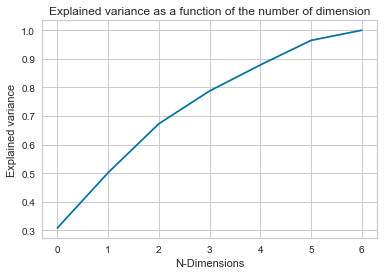

In [31]:
# Call the normal PCA and plot all components set to None
#--------------------------------------------------------------------
from watex.analysis import nPCA 
#---------------------------------------------------------------------
pca = nPCA (Xpca_scaled , return_X= False, view = True ) # return PCA object rather than the reduced X  

# **** comments: 
# here to 5/6 features are enought since the explained variance ration is already 
# got 98 % 

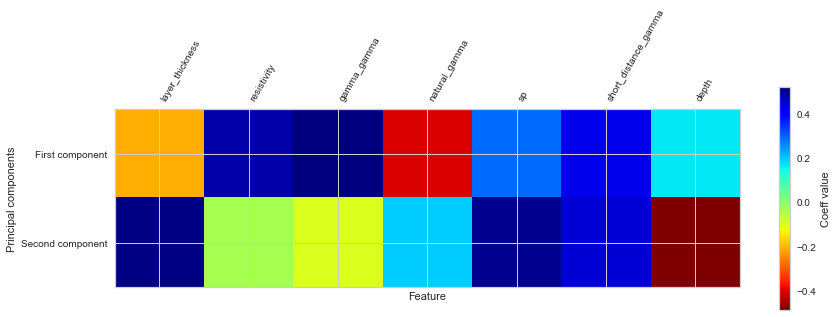

In [32]:
# Set the number of components and use  convenient plot the both components   
#-------------------------------------------------------------------------
from watex.utils import plot_pca_components 
#--------------------------------------------------------------------------
pca = nPCA (Xpca_scaled ,n_components=2,  return_X=False ) # return object for plot pupose 
 
components = pca.components_ 
features = pca.feature_names_in_
plot_pca_components (components, feature_names= features, cmap='jet_r') 

# **comments 
#  matrix plot shows the contributions of all features 
# -first components 
# while the most contributions are got in depth resistivity gamma and gamma short distane 
# they are negatively correlated with layer thichness , natural gamma. However 
# no-correlation is found with the sp log data 

# second components. depth and natural gamma are more corollated and inversely 
# correlated with the resistivity ga,,a, sp and shorth distance . 
# wheres the quasi-null correlation exist with layer thiickness . 
# by summaruze the PC1 abd pc2 analysis, all fetaures are usefull as prediction 
# and one of them can be skipped. This validated the explained variance ration where 
# under 8 features , after 7 deimensions , the explained variance ratio aleardy 
# reached 98 %.  Therefore features skipped shoould not influence the result of 
# prediction 


In [33]:
# we can auto-preprocess the data using the default pipe 
# categorical data "strata_name" is one-hoty-encoded and generate a sparse matrix ready  for the data for prediction 
# wee will ue the the function 'make_naive_pipe'
#-------------------------------------------------------------
from watex.utils  import make_naive_pipe 
#-------------------------------------------------------------
# auto scaled ythe data and store into a compressed format 
csr_data = make_naive_pipe(data_imputed, transform= True) # auto scaled the data using StandardScaler and  transform the data inplace 

# <1038x22 sparse matrix of type '<class 'numpy.float64'>'
# 	with 9336 stored elements in Compressed Sparse Row format> 
csr_data

<1038x21 sparse matrix of type '<class 'numpy.float64'>'
	with 8298 stored elements in Compressed Sparse Row format>

### Prediction of NGA labels 

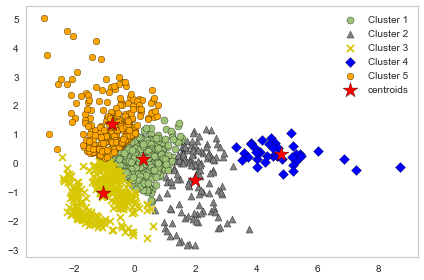

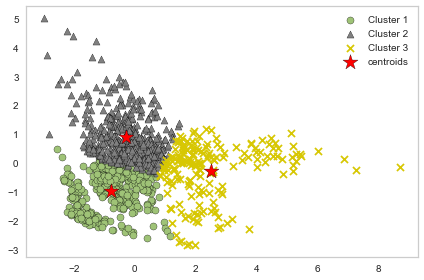

In [34]:
# We randomly set the number of cluster to 5 which maight correspond to 
# the number of aquifer group . KMeans is used to predict the  class label instead   
# and plot the clusters 
#------------------------------------------------------
from watex.exlib.sklearn import KMeans 
from watex.utils import plot_clusters 
#--------------------------------------------------------
# group the principal two most components of pca  into the 5 clusters 
km = KMeans (n_clusters =5 , init= 'random' )  
ykm = km.fit_predict(pca.X  ) 
km3c = KMeans (n_clusters =3 , init= 'random' )  
ykm3 = km3c.fit_predict(pca.X  ) 
plot_clusters (5 , pca.X, ykm , km.cluster_centers_ )  
plot_clusters (3 , pca.X, ykm3 , km3c.cluster_centers_ ) 



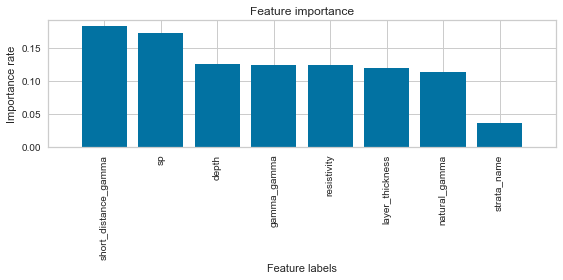

In [35]:
# plot the feature importances 
# we encode the strata_name and add it to the scale value 
# and plot_the feature  importances 
#------------------------------------------------------------
from watex.exlib.sklearn import RandomForestClassifier 
from watex.utils import plot_rf_feature_importances 
#------------------------------------------------------------

# add the strata_name to the remaining features 
strata_column =  pd.Series ( X ['strata_name'].astype ('category').cat.codes , name ='strata_name' )  
X_for_fi = pd.concat( [ strata_column , Xpca_scaled ], axis =1 ) 
# plot importance with the predicted label ykm  
plot_rf_feature_importances (RandomForestClassifier(), X_for_fi , y =ykm ) 


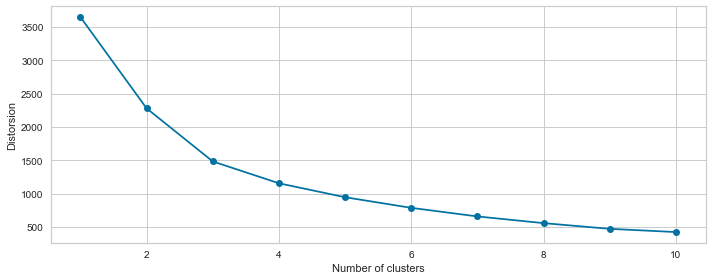

<AxesSubplot:xlabel='Number of clusters', ylabel='Distorsion'>

In [36]:
# plot elbow to confirm the 05 clustering of  aquifers 
#----------------------------------------
from watex.utils import plot_elbow 
#------------------------------------------
plot_elbow(pca.X, n_clusters=11)  

#***comments 
# as we can see , the elbow is located at k=3 that i.e can classify the aquifer 
# into three group in hongliu coal mine. 



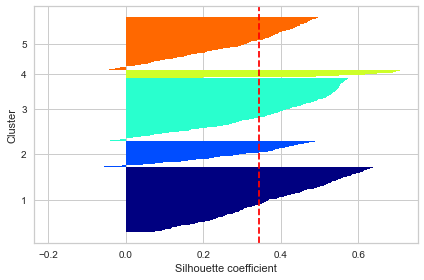

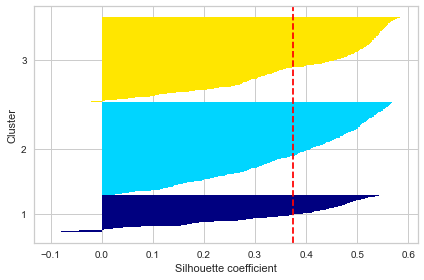

In [37]:
# let confirm this using the silhoutette plot from KMeans 
#----------------------------------------------
from watex.view import plotSilhouette 
#----------------------------------------

plotSilhouette (pca.X, labels =ykm , prefit =True)  # # plot silhouette for the 05 clusters qith pca reduced data 
plotSilhouette (pca.X, n_clusters= 3 , prefit =False)  # plot silhouettte for the three clusters by setting prefit to False since a new prediction is maed with 3 cluster under the hood 

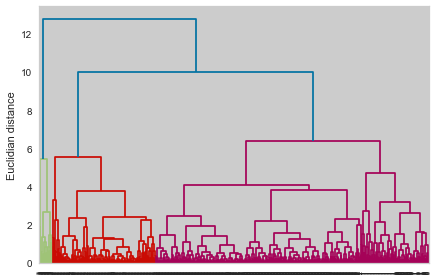

In [38]:
# plot the dendrogram from Hierrachical Agglomeration Clustering 
#-----------------------------------------------------
from watex.view import plotDendrogram
#------------------------------------------------
plotDendrogram (pca.X , labels = ykm)

#*** comments 
# in the case of MXS target , merging the predicted y with cluster =5 
# with create a lot of y=k33' where we expected to have a list a =balance target 
# with the true labels y (k1, k2 and k3 ) 
# there fore the clsuter with 3 labels is used instead of 5 
# thius yhe predicted NGLABwith true labels is combined with the 
# the true labels y for supervised learnings. Note that 
# the true labels are not altered by the predicted label y 
# not let plot the dendro heat 

In [39]:
# fit aquifer group and find the most representative of the true k labels to the predicted labels 
# ---test with the number of cluster set to 3 ---- 
#-------------------------------------------------------
from watex.utils.hydroutils import find_aquifer_groups , classify_k
#------------------------------------------------------
# categorize the k-values using the default func 
yk_map =classify_k (y.k , default_func =True)
groupobj = find_aquifer_groups (yk_map,  ykm ) 

In [40]:
groupobj

_AquiferGroup(Label=[' 1 ', 
                   Preponderance( rate = '53.141  %', 
                                [('Groups', {1: 0.419, 5: 0.33, 3: 0.148, 2: 0.064, 4: 0.039}),
                                 ('Representativity', ( '1', 0.42)),
                                 ('Similarity', '1')])],
             Label=[' 2 ', 
                   Preponderance( rate = ' 19.11  %', 
                                [('Groups', {5: 0.452, 1: 0.315, 2: 0.137, 4: 0.055, 3: 0.041}),
                                 ('Representativity', ( '5', 0.45)),
                                 ('Similarity', '5')])],
             Label=[' 3 ', 
                   Preponderance( rate = '27.749  %', 
                                [('Groups', {3: 0.462, 1: 0.387, 2: 0.142, 5: 0.009}),
                                 ('Representativity', ( '3', 0.46)),
                                 ('Similarity', '3')])],
             )